# Обучение модели сегментации повреждений. Unet

Попробуем обучить модель Unet в качетсве baseline модели для сегментации повреждений на автомобиле

### Установка и импорт библиотек

In [1]:
!pip install segmentation-models-pytorch albumentations opencv-python torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing inst

In [5]:
import os
import glob
import cv2
import numpy as np
import torch
import random
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchvision.utils import make_grid
from tqdm import tqdm

### Пути к данным

In [ ]:
base_path = "/kaggle/input/car-damage-segm/car-damage-detection-1"

train_img_paths = sorted(glob.glob(os.path.join(base_path, "train", "*.jpg")))
train_mask_paths = sorted(glob.glob(os.path.join(base_path, "train_masks", "*.png")))

val_img_paths = sorted(glob.glob(os.path.join(base_path, "valid", "*.jpg")))
val_mask_paths = sorted(glob.glob(os.path.join(base_path, "valid_masks", "*.png")))

test_img_paths = sorted(glob.glob(os.path.join(base_path, "test", "*.jpg")))
test_mask_paths = sorted(glob.glob(os.path.join(base_path, "test_masks", "*.png")))

### Процесс обучения модели

Класс датасета

In [ ]:
class DamageDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, i):
        image = cv2.imread(self.image_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)


Применим аугментации к изображениям
 - Все изображения приведены к размеру 640х640, есть мелкие повреждения, делать Resize (уменьшать разрешение) не будем

In [ ]:
train_tfms = A.Compose([
    # A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(),
    ToTensorV2(),
])

val_tfms = A.Compose([
    # A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2(),
])

In [ ]:
train_ds = DamageDataset(train_img_paths, train_mask_paths, transform=train_tfms)
val_ds = DamageDataset(val_img_paths, val_mask_paths, transform=val_tfms)
test_ds = DamageDataset(test_img_paths, test_mask_paths, transform=val_tfms)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=4)
test_dl = DataLoader(test_ds, batch_size=4)

Создание модели
 - В качестве функции потерь будем использовать DiceLoss, так как он более устойчив к сильному дисбалансу классов, характерному для подобных данных, где повреждение занимает лишь небольшую часть изображения.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="efficientnet-b2",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
).to(device)

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /Users/alexandr/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [04:58<00:00, 123kB/s] 


Метрики качества
В качетсве метрик качетсва будем использовать:
 - Damage IoU (IoU относящийся к повреджениям)
 - Background IoU (IoU относящийся к фону)
 - Mean IoU (усредненный IoU)
 - Accuracy

In [ ]:
train_losses_epoch, val_losses_epoch = [], []
damage_ious_epoch, background_ious_epoch, accuracies_epoch, mean_ious_epoch = [], [], [], []

def calculate_metrics(preds_bin, masks):
    preds_bin = preds_bin.bool()
    masks = masks.bool()
    tp = (preds_bin & masks).sum((1,2,3)).float()
    tn = (~preds_bin & ~masks).sum((1,2,3)).float()
    fp = (preds_bin & ~masks).sum((1,2,3)).float()
    fn = (~preds_bin & masks).sum((1,2,3)).float()
    damage_iou = (tp + 1e-6) / (tp + fp + fn + 1e-6)
    background_iou = (tn + 1e-6) / (tn + fp + fn + 1e-6)
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)
    return damage_iou.mean().item(), background_iou.mean().item(), accuracy.mean().item()


Функции для одной эпохи обучения и для последующей валидации

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0
    for images, masks in tqdm(loader):
        images, masks = images.to(device), masks.to(device)
        preds = model(images)
        loss = loss_fn(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader):
    model.eval()
    total_loss = 0
    total_damage_iou, total_background_iou, total_accuracy, mean_iou = 0, 0, 0, 0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = loss_fn(preds, masks)
            total_loss += loss.item()
            preds_bin = (preds > 0.5).float()
            d_iou, b_iou, acc = calculate_metrics(preds_bin, masks)
            total_damage_iou += d_iou
            total_background_iou += b_iou
            total_accuracy += acc
    n = len(loader)
    mean_iou = (total_damage_iou + total_background_iou) / (2 * n)
    return total_loss / n, total_damage_iou / n, total_background_iou / n, total_accuracy / n, mean_iou


Процесс обучения
 - Обучения будем производить 25 эпох, если loss не падает в течение 5 эпох, то обучение останавливается

In [ ]:
EPOCHS = 25
PATIENCE = 5

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_dl)
    val_loss, d_iou, b_iou, acc, mean_iou = validate(model, val_dl)
    val_losses_epoch.append(val_loss)
    train_losses_epoch.append(train_loss)
    damage_ious_epoch.append(d_iou)
    background_ious_epoch.append(b_iou)
    mean_ious_epoch.append(mean_iou)
    accuracies_epoch.append(acc)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Damage IoU={d_iou:.4f}, Background IoU={b_iou:.4f}, Mean IoU={mean_iou:.4f}, Accuracy={acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

model.load_state_dict(best_model_state)


100%|██████████| 400/400 [03:05<00:00,  2.15it/s]


Epoch 1: Train Loss=0.4156, Val Loss=0.3795, Damage IoU=0.4643, Background IoU=0.9616, Mean IoU=0.7129, Accuracy=0.9638


100%|██████████| 400/400 [03:06<00:00,  2.15it/s]


Epoch 2: Train Loss=0.3223, Val Loss=0.3236, Damage IoU=0.4990, Background IoU=0.9650, Mean IoU=0.7320, Accuracy=0.9669


100%|██████████| 400/400 [03:07<00:00,  2.13it/s]


Epoch 3: Train Loss=0.2793, Val Loss=0.3349, Damage IoU=0.4600, Background IoU=0.9670, Mean IoU=0.7135, Accuracy=0.9685


100%|██████████| 400/400 [03:07<00:00,  2.13it/s]


Epoch 4: Train Loss=0.2542, Val Loss=0.3063, Damage IoU=0.4974, Background IoU=0.9686, Mean IoU=0.7330, Accuracy=0.9702


100%|██████████| 400/400 [03:04<00:00,  2.16it/s]


Epoch 5: Train Loss=0.2329, Val Loss=0.2840, Damage IoU=0.5344, Background IoU=0.9662, Mean IoU=0.7503, Accuracy=0.9683


100%|██████████| 400/400 [03:08<00:00,  2.12it/s]


Epoch 6: Train Loss=0.2152, Val Loss=0.2715, Damage IoU=0.5419, Background IoU=0.9691, Mean IoU=0.7555, Accuracy=0.9709


100%|██████████| 400/400 [03:23<00:00,  1.97it/s]


Epoch 7: Train Loss=0.2016, Val Loss=0.2619, Damage IoU=0.5526, Background IoU=0.9704, Mean IoU=0.7615, Accuracy=0.9722


100%|██████████| 400/400 [03:14<00:00,  2.06it/s]


Epoch 8: Train Loss=0.1884, Val Loss=0.2652, Damage IoU=0.5414, Background IoU=0.9707, Mean IoU=0.7560, Accuracy=0.9724


100%|██████████| 400/400 [03:08<00:00,  2.12it/s]


Epoch 9: Train Loss=0.1769, Val Loss=0.2635, Damage IoU=0.5564, Background IoU=0.9706, Mean IoU=0.7635, Accuracy=0.9722


100%|██████████| 400/400 [03:07<00:00,  2.14it/s]


Epoch 10: Train Loss=0.1745, Val Loss=0.2647, Damage IoU=0.5501, Background IoU=0.9705, Mean IoU=0.7603, Accuracy=0.9721


100%|██████████| 400/400 [03:08<00:00,  2.12it/s]


Epoch 11: Train Loss=0.1586, Val Loss=0.2541, Damage IoU=0.5556, Background IoU=0.9719, Mean IoU=0.7637, Accuracy=0.9735


100%|██████████| 400/400 [03:05<00:00,  2.16it/s]


Epoch 12: Train Loss=0.1578, Val Loss=0.2650, Damage IoU=0.5530, Background IoU=0.9709, Mean IoU=0.7619, Accuracy=0.9725


100%|██████████| 400/400 [03:07<00:00,  2.14it/s]


Epoch 13: Train Loss=0.1499, Val Loss=0.2532, Damage IoU=0.5692, Background IoU=0.9721, Mean IoU=0.7707, Accuracy=0.9736


100%|██████████| 400/400 [03:02<00:00,  2.19it/s]


Epoch 14: Train Loss=0.1525, Val Loss=0.2542, Damage IoU=0.5576, Background IoU=0.9701, Mean IoU=0.7639, Accuracy=0.9720


100%|██████████| 400/400 [03:08<00:00,  2.13it/s]


Epoch 15: Train Loss=0.1438, Val Loss=0.2567, Damage IoU=0.5586, Background IoU=0.9732, Mean IoU=0.7659, Accuracy=0.9746


100%|██████████| 400/400 [03:03<00:00,  2.18it/s]


Epoch 16: Train Loss=0.1407, Val Loss=0.2497, Damage IoU=0.5734, Background IoU=0.9733, Mean IoU=0.7733, Accuracy=0.9748


100%|██████████| 400/400 [03:04<00:00,  2.17it/s]


Epoch 17: Train Loss=0.1352, Val Loss=0.2498, Damage IoU=0.5730, Background IoU=0.9730, Mean IoU=0.7730, Accuracy=0.9745


100%|██████████| 400/400 [03:06<00:00,  2.15it/s]


Epoch 18: Train Loss=0.1326, Val Loss=0.2598, Damage IoU=0.5577, Background IoU=0.9737, Mean IoU=0.7657, Accuracy=0.9750


100%|██████████| 400/400 [03:13<00:00,  2.06it/s]


Epoch 19: Train Loss=0.1276, Val Loss=0.2399, Damage IoU=0.5831, Background IoU=0.9730, Mean IoU=0.7780, Accuracy=0.9745


100%|██████████| 400/400 [03:13<00:00,  2.06it/s]


Epoch 20: Train Loss=0.1237, Val Loss=0.2364, Damage IoU=0.5891, Background IoU=0.9741, Mean IoU=0.7816, Accuracy=0.9756


100%|██████████| 400/400 [03:05<00:00,  2.16it/s]


Epoch 21: Train Loss=0.1172, Val Loss=0.2465, Damage IoU=0.5791, Background IoU=0.9744, Mean IoU=0.7768, Accuracy=0.9758


100%|██████████| 400/400 [03:06<00:00,  2.14it/s]


Epoch 22: Train Loss=0.1143, Val Loss=0.2479, Damage IoU=0.5794, Background IoU=0.9739, Mean IoU=0.7766, Accuracy=0.9753


100%|██████████| 400/400 [03:02<00:00,  2.19it/s]


Epoch 23: Train Loss=0.1158, Val Loss=0.2383, Damage IoU=0.5903, Background IoU=0.9748, Mean IoU=0.7826, Accuracy=0.9762


100%|██████████| 400/400 [03:02<00:00,  2.20it/s]


Epoch 24: Train Loss=0.1111, Val Loss=0.2344, Damage IoU=0.6052, Background IoU=0.9727, Mean IoU=0.7890, Accuracy=0.9743


100%|██████████| 400/400 [03:04<00:00,  2.17it/s]


Epoch 25: Train Loss=0.1114, Val Loss=0.2361, Damage IoU=0.5909, Background IoU=0.9738, Mean IoU=0.7823, Accuracy=0.9753


<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), "u_net_car_damage.pth")

Графики изменения лосса и метрик по эпохам

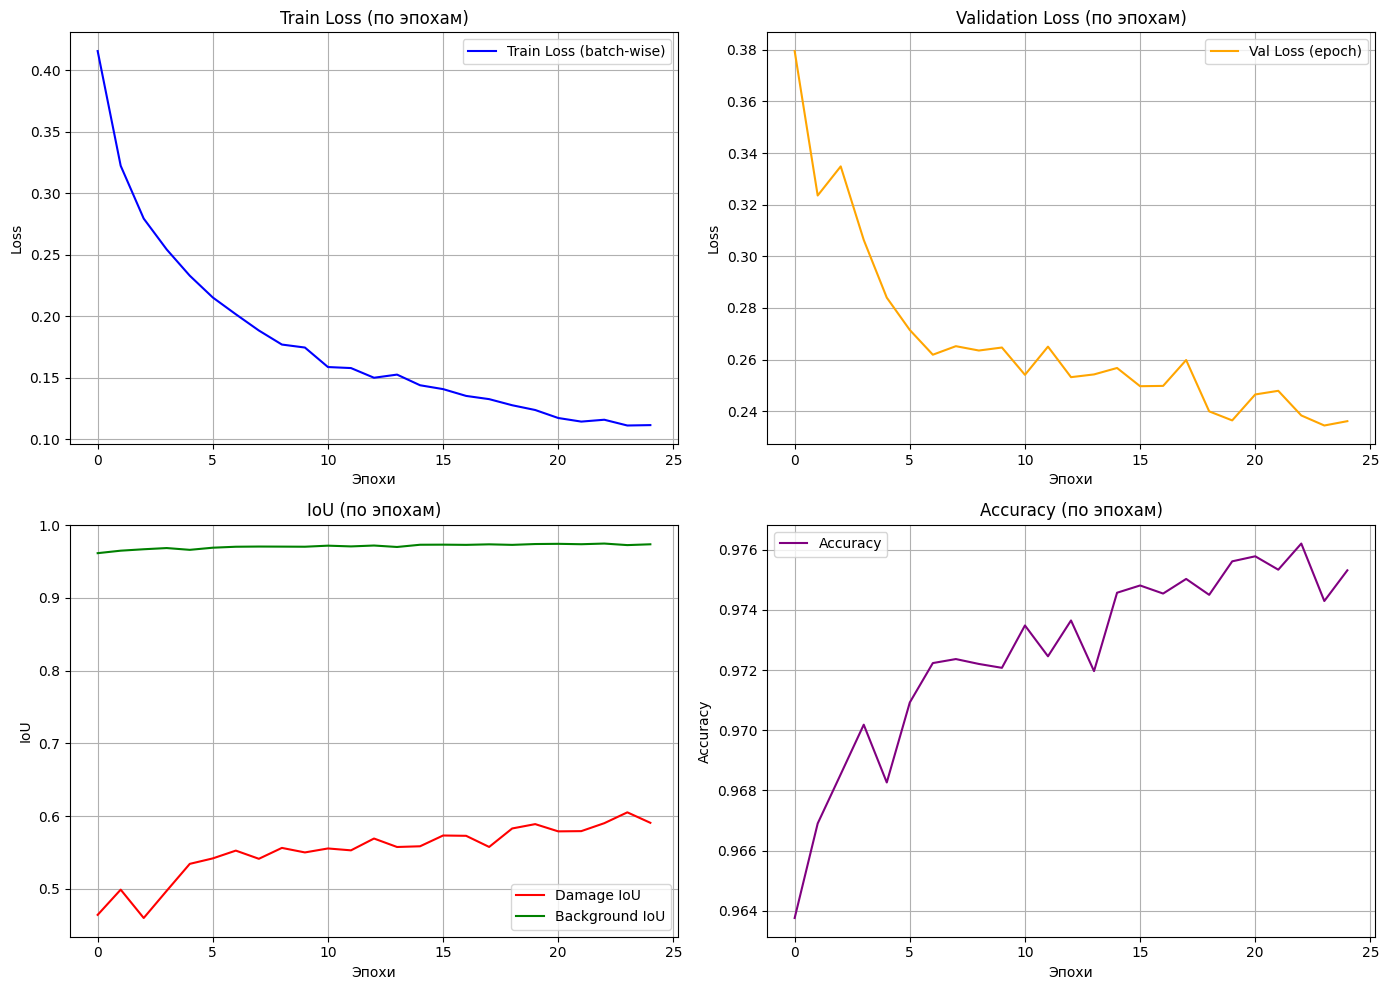

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses_epoch, label="Train Loss (batch-wise)", color='blue')
plt.title("Train Loss (по эпохам)")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(val_losses_epoch, label="Val Loss (epoch)", color='orange')
plt.title("Validation Loss (по эпохам)")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(damage_ious_epoch, label="Damage IoU", color='red')
plt.plot(background_ious_epoch, label="Background IoU", color='green')
plt.title("IoU (по эпохам)")
plt.xlabel("Эпохи")
plt.ylabel("IoU")
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(accuracies_epoch, label="Accuracy", color='purple')
plt.title("Accuracy (по эпохам)")
plt.xlabel("Эпохи")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Метрики лучшей модели:
 - Damage IoU - 0.6052
 - Background IoU - 0.9727
 - Mean IoU - 0.7890
 - Accuracy - 0.9753

### Анализ работы модели

Загрузим лучшую модель

In [ ]:
model.load_state_dict(torch.load("./u_net_car_damage.pth", map_location='cpu'))
model.eval()

/var/folders/_d/y6vnp4sn345d2qqhlsv3qg6r0000gn/T/ipykernel_53002/1905155404.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/alex

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

Пример работы модели

In [21]:
def visualize_prediction(image_path, mask_path=None):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = A.Normalize()(image=image_rgb)["image"]
    image_tensor = ToTensorV2()(image=image_tensor)["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(image_tensor)[0, 0].cpu().numpy()
        pred_mask = (pred > 0.5).astype(np.uint8)

    if mask_path:
        gt = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        gt = cv2.resize(gt, (256, 256))
    else:
        gt = np.zeros_like(pred_mask)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt, cmap='gray')
    plt.title('Ground Truth' if mask_path else 'No Ground Truth')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image_rgb)
    plt.imshow(pred_mask, alpha=0.5, cmap='Reds')
    plt.title('Predicted Damage')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


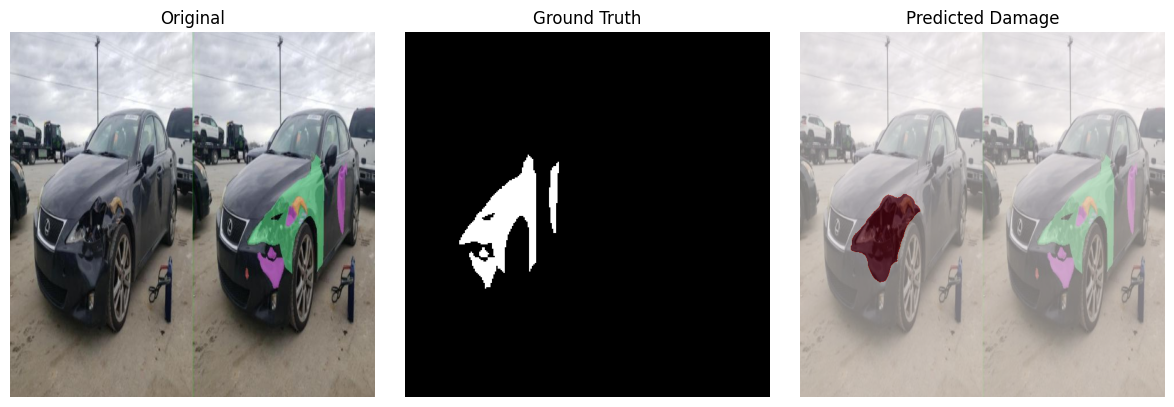

In [30]:
sample = random.randint(0, 224)
sample_image = test_img_paths[sample]
sample_mask = test_mask_paths[sample]
visualize_prediction(sample_image, sample_mask)

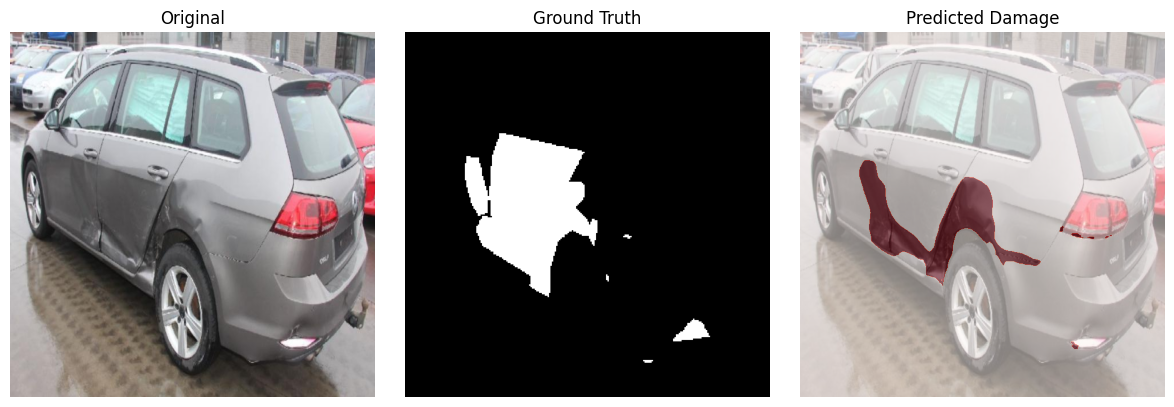

In [36]:
sample = random.randint(0, 224)
sample_image = test_img_paths[sample]
sample_mask = test_mask_paths[sample]
visualize_prediction(sample_image, sample_mask)

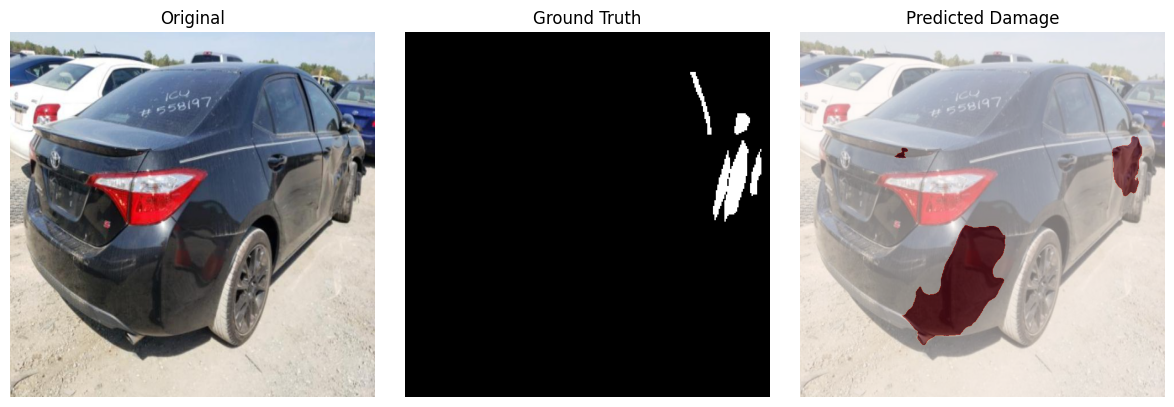

In [41]:
sample = random.randint(0, 224)
sample_image = test_img_paths[sample]
sample_mask = test_mask_paths[sample]
visualize_prediction(sample_image, sample_mask)

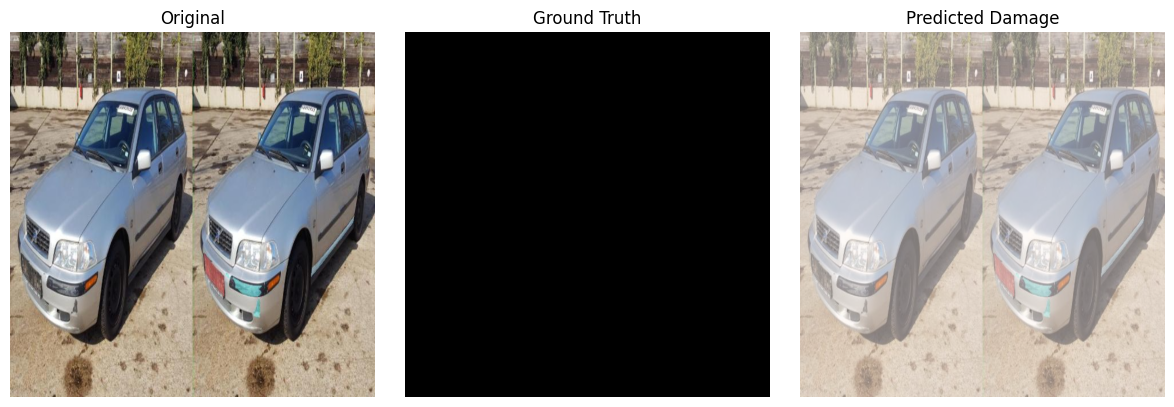

In [50]:
sample = random.randint(0, 224)
sample_image = test_img_paths[sample]
sample_mask = test_mask_paths[sample]
visualize_prediction(sample_image, sample_mask)

Результаты визуального анализа демонстрируют, что модель успешно распознаёт крупные повреждённые участки на изображениях, хорошо совпадая с контуром реальных дефектов, также в большинстве случаев, если на автомобиле нет повреждений, модель работает корректно. Однако в ряде случаев наблюдается избыточное сегментирование — маска расширяется за пределы истинных границ повреждений. Мелкие и изолированные дефекты модель распознаёт хуже: часть мелких элементов теряется. При этом на синтетических изображениях модель работает значительно увереннее и предсказания в этих случаях более точные. Такое поведение может говорить о частичном переобучении на синтетические данные и недостаточной адаптации к реальным условиям